# Dimensionality reduction

In [2]:
!date

Thu 22 Apr 2021 11:40:13 AM CEST


When assessing the model performance, we are interested in two things:
- **prediction** - how accurate our model is when applied to the new data
- **interpretability** - what features are important for prediction, how are they important and how they interact

There is very often a trade-off between model interpretability and model performance - if we increase the complexity
of the model it will likely perform better, but it will get harder to interpret it correctly. For example, linear
models and simple tree-based models can be easily interpreted because what they do is very intuitive, but
for complex tasks they may be less accurate because they can easily under- or overfit. On the other hand, more
complex models, like Random Forest, or to an extreme, deep neural networks, are often hard to interpret even if their
performance is very good. So it boils down to what you want to get from your model.

A general rule in machine learning is *'the more the merrier'*. Even the simplest models will generally perform better
when trained on bigger data sets, and with more measured features, one expects to be able to explain more of the
variance in the data. However, working with high dimensional data sometimes can be problematic.

Naturally, the data with fewer dimensions are easier to understand, visualize and interpret. Having a lot of dimensions
can mean that your data points are far away from virtually every other point, which makes the distances between the
data points uninformative - this is often referred to as **the curse of dimensionality**.

To deal with this, before fitting our model we need to perform some sort of dimensionality reduction.

The first possible solution is to look for the effective dimensionality of your data. In data sets where some features
are irrelevant, the effective dimensionality might be much smaller than the actual number of the features. In this case,
we can use one of the **feature selection** algorithms to identify only the informative features. Another solution would be to try to project your original features into a lower dimensional space - ths is what
**feature extraction** does.

The two approaches are similar in the sense that they both reduce the dimensionality of the data, but there is an
important difference: **feature selection selects features to keep or remove from the dataset, whereas feature
extraction creates a projection of the data resulting in entirely new input features.**

## Feature selection

Feature selection is typically done when working with datasets that have many more features than observations.
For example, n patient samples and for each we have p measured characteristics, e.g. genes expression, and
p>>n. Why is this problematic, and why our models generally won't perform well with this kind of data?
Because there is essentially not enough observations to cover all the possible combinations of features.

Several most commonly used feature selection methods to consider in this case are:
- variance feature selection
- lasso
- ridge
- elastic net

To showcase feature selection and extraction approaches, we will work with the
[Human lung carcinomas microarray dataset](https://doi.org/10.1073/pnas.191502998) from Bhattacharjee et al. We will use
this example to also show some preprocessing steps you might want to apply befor fitting the model.


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

Load the data.

In [4]:
data = pd.read_csv("./data/DatasetA_12600gene.csv", header=0)
data.head()
print(data.shape)
data.columns

(12600, 204)


Index(['probe set', 'AD-043T2-A7-1', 'AD-111T2-A8-1', 'AD-114T1-A9-1 *',
       'AD-115T1-A12-1 *', 'AD-118t1-A13-1', 'AD-119t3-A195-8',
       'AD-120t1-A226-8 *', 'AD-122t3-A197-8', 'AD-123T1-A25-1 *',
       ...
       'COID-COID14t1-A351-6', 'COID-COID16t1-A352-6', 'COID-COID18t1-A353-6',
       'COID-COID3t1-A340-6', 'COID-COID4t1-A341-6', 'COID-COID5t1-A342-6',
       'COID-COID6t1-A343-6', 'COID-COID7t1-A344-6', 'COID-COID8t1-A345-6',
       'COID-COID9t1-A346-6'],
      dtype='object', length=204)

We see there is one categorical variable ('probe set', containing probe i.e. gene names) and 203 numerical ones (samples).
We can summarize numeric columns in the data:

In [5]:
data.describe()

,AD-043T2-A7-1,AD-111T2-A8-1,AD-114T1-A9-1 *,AD-115T1-A12-1 *,AD-118t1-A13-1,AD-119t3-A195-8,AD-120t1-A226-8 *,AD-122t3-A197-8,AD-123T1-A25-1 *,AD-127T1-A14-1,...,COID-COID14t1-A351-6,COID-COID16t1-A352-6,COID-COID18t1-A353-6,COID-COID3t1-A340-6,COID-COID4t1-A341-6,COID-COID5t1-A342-6,COID-COID6t1-A343-6,COID-COID7t1-A344-6,COID-COID8t1-A345-6,COID-COID9t1-A346-6
count,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,...,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000
mean,100.239417,100.899244,91.333506,104.118275,93.203437,93.431129,105.971492,106.203029,95.834106,109.298414,...,121.672475,122.578717,114.799799,121.250127,110.563802,140.542330,100.358783,107.931560,123.265077,109.563598
std,316.449063,338.082066,334.014628,338.423800,339.088615,343.338231,339.469545,339.694939,338.375711,343.273469,...,295.392617,328.506923,339.944349,331.701264,326.656284,294.820844,334.361438,304.089469,326.938184,329.891901
min,-745.160000,-671.920000,-534.135000,-1005.060000,-656.200000,-603.340000,-682.200000,-792.340000,-564.180000,-610.640000,...,-588.680000,-898.380000,-871.820000,-876.930000,-773.500000,-1057.980000,-877.230000,-845.550000,-795.820000,-757.850000
25%,2.440000,11.240000,0.748750,7.915000,-1.980000,-6.040000,3.542500,3.610000,0.080000,11.810000,...,30.690000,13.330000,-2.360000,13.710000,1.680000,49.010000,-9.670000,15.630000,27.360000,-3.920000
50%,27.540000,30.360000,19.705000,30.580000,18.780000,16.190000,29.160000,28.780000,20.595000,35.320000,...,54.450000,42.200000,29.320000,41.330000,29.070000,71.050000,16.170000,38.160000,53.150000,25.710000
75%,92.400000,79.200000,69.256250,88.703750,71.920000,74.700000,94.347500,94.330000,75.585000,92.920000,...,114.670000,115.700000,111.610000,112.000000,102.980000,133.110000,87.310000,98.850000,113.690000,106.202500
max,7322.580000,7077.040000,8056.020000,7132.050000,7254.320000,6935.870000,6715.070000,7147.730000,6935.240000,7202.390000,...,8751.660000,7355.160000,8011.270000,8129.800000,7917.870000,8726.120000,8064.240000,7555.490000,8274.780000,8073.710000


For downstream work, we will transform the data to have samples as rows and genes (probes) as columns.

In [6]:
# input matrix with features as columns
dt = data.transpose()
cols = dt.iloc[0]
dt = dt.iloc[3:,]
dt.columns = cols
dt = dt.apply(pd.to_numeric, errors='coerce')
dt.head()

probe set,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
AD-114T1-A9-1 *,-2.175,-2.21,-0.060,6.320,-1.775,-16.53,-3.610,16.410,-17.970,-57.020,...,67.44,14.610,10.875,10.615,35.140,1.745,29.710,10.465,-42.63,73.735
AD-115T1-A12-1 *,-1.540,21.75,5.835,23.815,-24.785,-12.89,-4.485,19.500,-21.445,-47.205,...,133.94,9.615,27.355,30.860,48.710,10.355,40.845,54.615,-71.38,65.435
AD-118t1-A13-1,-9.070,3.08,-1.980,17.260,-10.090,-15.15,-18.190,13.210,-13.130,-39.470,...,99.23,-14.140,23.340,6.120,33.460,-10.090,40.550,16.250,-48.59,39.540
AD-119t3-A195-8,-16.580,-20.09,-8.390,4.490,-18.920,-20.09,-8.390,16.190,-38.820,-56.380,...,127.33,13.850,8.000,75.870,37.260,-11.900,24.390,54.810,-47.02,59.490
AD-120t1-A226-8 *,-15.895,10.88,1.610,23.845,-21.980,-29.00,-3.865,23.635,-19.010,-65.195,...,189.52,13.755,25.300,12.680,53.485,6.920,48.120,42.560,-81.71,39.965


Outlier samples can influence the model performance. We identify potential outliers as those with mean z value higher
than 1.

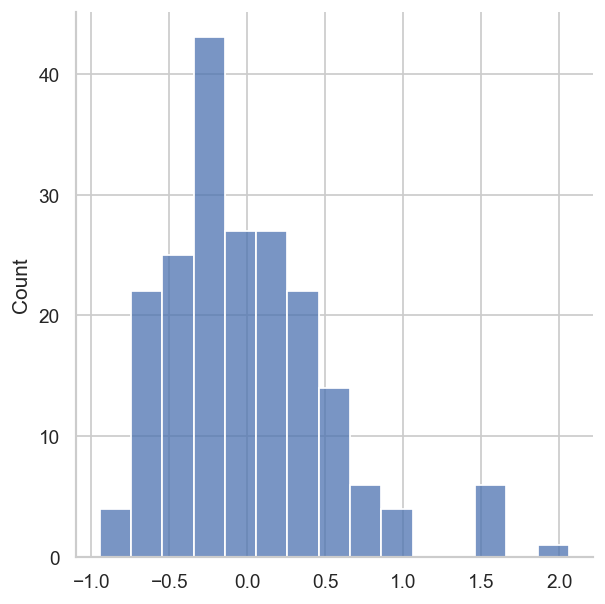

In [7]:
from scipy.stats import zscore

dtzscore = dt.apply(zscore).mean(axis=1)
sns.displot(dtzscore)

Whether to remove the outliers is not always straightforward, and it largely depends on the data, the used model and
the question we want to answer. If unsure, the bast thing to do would be to fit the same model with or without outliers
and see how it influences the model performance. Here we don't remove the outliers.

In [8]:
#outliers = dtzscore[abs(dtzscore)>1.5].index
#print(outliers)
#dt = dt.drop(outliers, axis=0)
#dt.shape

Classes of samples we are working with are described in the original publication:


* normal lung (NL)
* neuroendocrine tumors
  * small-cell lung cancer (SMCL)
  * pulmonary carcinoids (COID)
* squamous cell lung carcinoma (SQ)
* adenocarcinomas (AD)

We can extract tumor class indicators from sample names - this class information will help us inspect the data and
assess how it is affected by different dimensionality reduction approaches.

In [9]:
samples = pd.Series(list(dt.index)[0:])
classes = samples.str.extract(r'(AD|NL|SMCL|SQ|COID)')
classes.value_counts()

AD      137
SQ       21
COID     20
NL       17
SMCL      6
dtype: int64

We can also summarize the expression of each gene by tumor class, but given the very large number of genes, this still
doesn't give us any idea what are the important signature genes for a particular class, or any other information we
might want to obtain from this type of data.

In [10]:
dt['Class'] = classes.values
dt.groupby(['Class']).mean()

probe set,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
Class,,,,,,,,,,,,,,,,,,,,,
AD,-9.087269,4.543054,0.928406,19.269064,-13.156089,-18.529660,-5.172013,24.822834,-21.958954,-52.713260,...,133.349664,7.258388,19.817749,15.594775,44.188588,2.528340,36.428242,30.383193,-58.709681,69.901746
COID,13.829500,28.331500,18.926000,42.112500,-5.235500,-9.738500,14.539000,35.837500,-18.217000,-46.033500,...,212.381500,9.659500,31.112000,48.095000,69.513500,20.926500,34.480500,48.644000,-24.081500,96.400000
NL,-18.127647,-7.629412,-10.631176,13.154706,-32.394706,-44.083529,-7.740000,14.532353,-31.537647,-57.608235,...,105.974118,-7.731765,2.073529,-4.917059,34.986471,-8.917059,31.642353,34.871765,-86.042941,55.991176
SMCL,13.911667,21.578333,12.183333,32.351667,-12.508333,-26.431667,-0.141667,32.843333,-23.228333,-57.068333,...,142.985000,5.060000,34.220000,28.976667,78.450000,17.088333,57.003333,46.591667,-52.905000,74.198333
SQ,-18.898571,-9.160000,-14.440000,4.210476,-28.203333,-37.127619,-16.997143,-0.824286,-36.459048,-59.486667,...,135.947143,3.051905,4.211429,-4.859524,23.317619,-12.938095,39.040476,24.648571,-89.865714,68.809048


We could attempt, for example, to cluster the samples and identify the important genes for each class. However, as the
number of features is very high, this would not work very well. We want to preselect the features first.
In the original publication, authors did this by simply selecting variable genes using a standard deviation threshold
of 50 expression units. We will show this approach, as well as several alternatives.

To be able to evaluate alternative feature selection approaches, we split data into training and test set. If we have
very few features and score is poor, it's likely that we are under-fitting or not generalizing enough. On the other
hand, if we have many features, and the train score is good, but the test score is poor, we are over-fitting.

In [11]:
from sklearn.model_selection import train_test_split

target_column = ['Class']
predictors = list(set(list(dt.columns))-set(target_column))
X = dt[predictors].values
Y = dt[target_column]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1240)
print(X_train.shape); print(X_test.shape)
print(np.unique(Y_train)); print(np.unique(Y_test))

(140, 12600)
(61, 12600)
['AD' 'COID' 'NL' 'SMCL' 'SQ']
['AD' 'COID' 'NL' 'SMCL' 'SQ']


### Variance feature selection

The simplest approach for selecting important features would be to simply select those that have high variance.
Intuitively, low variance means the values of the feature are very similar, and will not help the model very much to
discriminate different samples, classes or outcomes. That's why we want to retain only the variable features.

There are 12600 features in our data. We inspect the distribution of their variance and perform feature selection.

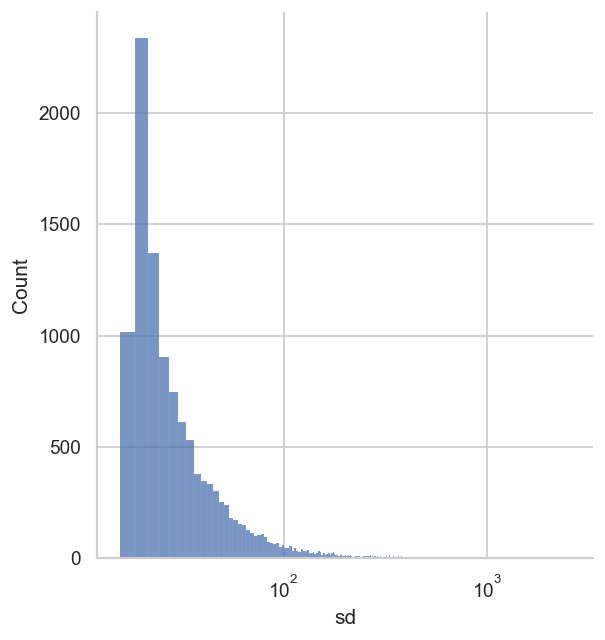

In [12]:
sns.displot(X.std(axis=0)).set(xlabel='sd',xscale='log')

We need to decide on a threshold for which features to exclude. In the original publication, the authors have used a sd
threshold of 50 expression units to select the around 3.5k most variable features. We repeat the same here.

In [13]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(50**2)
selector.fit(X)
X[:,selector.get_support()].shape

(201, 3552)

We selected 3552 most variable features. Now we evaluate how discriminative they are by fitting a logistic regression
model on the train-test split.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# fit a model
logreg = LogisticRegression(penalty='none', random_state=3214) # default is l2, which we will discuss later
lr = logreg.fit(X_train[:,selector.get_support()], Y_train.values.ravel())

# predictions on test set
pred_train_lr = lr.predict(X_train[:,selector.get_support()])
print(accuracy_score(Y_train,pred_train_lr))

# predictions on train set
pred_test_lr = lr.predict(X_test[:,selector.get_support()])
print(accuracy_score(Y_test,pred_test_lr))

1.0
0.9508196721311475


The important downside of this simple feature selection approach is that it only considers the input features and
doesn't take the dependent variable into account. It is therefore primarily useful for the unsupervised modelling.

Another downside is that features with higher absolute values will tend to have higher variance (a nice technical term
for this is *heteroscedasticity*), so that the performance of any model we choose downstream will be dominated by the
most highly expressed genes. We can mitigate this by scaling the features. Try this and see how it affects the model
performance.

### Lasso

Lasso (least absolute shrinkage and selection operator) is a method that does two things: variable selection and
regularization. Regularization is a term used for constraining or shrinking the coefficient estimates in your model
towards zero - this 'discourages' learning a more complex or flexible model, to avoid the risk of overfitting.
How is this done? You might remember from regression lecture that the coefficients of a model are chosen to minimize
the residual sum of squares (RSS)


$$ RSS = \sum_{i=1}^{N} (\hat y - y)^2 $$

where $$ \hat y = \beta_{0} + \sum_{i=1}^{N} \beta_{i}x $$

Lasso (also termed L1 regularization) adds an element that penalizes models coefficients (high coefficients ~ high
flexibility), and the function that is minimized is then:

$$ RSS + \lambda \sum_{i=1}^{N}  |\beta_{i}| $$

Here $$ \lambda $$ is the tuning parameter that determines how much we want to penalize the coefficients. When
$$ \lambda = 0 $$, the penalty term has no effect, and as it is increased, the impact of the shrinkage increases too, and
the resulting coefficients approach zero.

In [15]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=int(1e6), random_state=6872)
lsr = lasso.fit(X_train, Y_train.values.ravel())

# predictions on test set
pred_train_lsr = lsr.predict(X_train)
print(accuracy_score(Y_train,pred_train_lsr))

# predictions on train set
pred_test_lsr = lsr.predict(X_test)
print(accuracy_score(Y_test,pred_test_lsr))

1.0
0.9344262295081968


An important parameter here is `C`, the inverse of regularization strength ($$c \sim 1/\lambda$$). It must have a
positive value, and smaller values specify stronger regularization. We can evaluate model performance with different
values of `C`.

In [16]:
def eval_reg(
        x_train, x_test, y_train, y_test,
        cs = np.logspace(-2, 8, 11), penalty = 'l1', solver = 'liblinear', l1_ratio = None,
        seed = 4135):

  from time import time

  print("Computing regularization path ...")
  start = time()
  reg = LogisticRegression(penalty=penalty, solver=solver, l1_ratio=l1_ratio, max_iter=int(1e6), warm_start=True, random_state=seed)
  coefs_ = []
  acc_train_ = []
  acc_test_ = []
  for c in cs:
    reg.set_params(C=c)
    regfit = reg.fit(x_train, y_train.values.ravel())
    coefs_.append(regfit.coef_.ravel().copy())

    pred_train = regfit.predict(X_train)
    acc_train_.append(accuracy_score(y_train,pred_train))

    pred_test = regfit.predict(x_test)
    acc_test_.append(accuracy_score(y_test,pred_test))

  print("This took %0.3fs" % (time() - start))
  coefs_ = np.array(coefs_)

  ldt = pd.DataFrame(data={
      'log(C)' : np.log10(cs),
      'train' : acc_train_,
      'test' : acc_test_
  }).melt(id_vars='log(C)',value_name="accuracy",var_name="data")
  sns.lineplot(x="log(C)", y="accuracy", hue="data", data=ldt)

  return coefs_

Computing regularization path ...
This took 19.585s


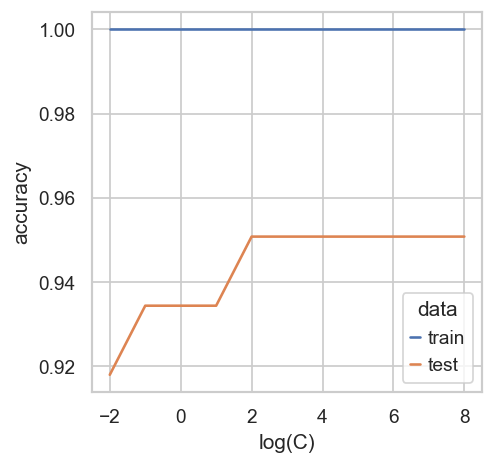

In [17]:
l1_coeffs = eval_reg(X_train, X_test, Y_train, Y_test, penalty="l1")

Inspect coefficients.

In [18]:
cdt = pd.DataFrame(data=l1_coeffs).set_index(np.logspace(-2, 8, 11))
cdt.transpose().abs().describe()

,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03,1.000000e+04,1.000000e+05,1.000000e+06,1.000000e+07,1.000000e+08
count,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000
mean,0.000001,0.000002,0.000005,0.000009,0.000038,0.000123,0.000255,0.000326,0.000340,0.000341,0.000342
std,0.000034,0.000047,0.000060,0.000091,0.000277,0.000582,0.000768,0.000804,0.000809,0.000809,0.000809
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000023,0.000031,0.000032,0.000032
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000045,0.000103,0.000116,0.000118,0.000118
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000041,0.000222,0.000333,0.000354,0.000356,0.000357
max,0.002285,0.003176,0.003434,0.005009,0.016991,0.036398,0.046795,0.046880,0.046888,0.046889,0.046889


Note that Lasso shrinks the less important feature’s coefficient to zero, i.e. it removes some feature altogether.

In [19]:
def plot_coeffs_dist(coeffs, cs=np.logspace(-2, 8, 11)):
    pd.DataFrame(data=coeffs).set_index(cs)
    cdt['C'] = cdt.index
    cdtm = cdt.melt( id_vars='C',value_name="coeff")
    cdtm['log(C)'] = np.log10(cdtm['C'])
    cdtm['abscoeff'] = abs(cdtm['coeff'])
    ax = sns.boxplot(x='log(C)',y='abscoeff',data=cdtm, showfliers = True)
    ax.set_yscale('symlog',linthresh=1e-10)
    ax.set(ylim=-1e-10)
    #plt.xticks(rotation=90)
    plt.show()

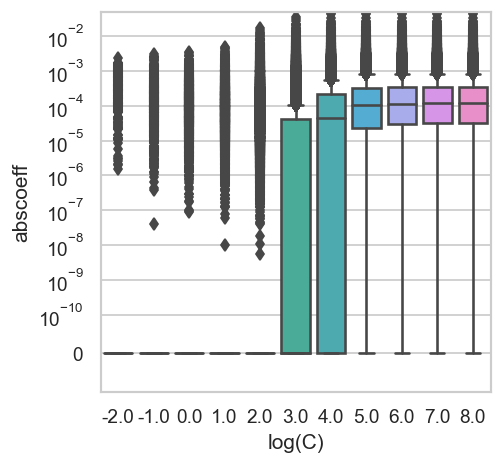

In [20]:
plot_coeffs_dist(l1_coeffs)

We choose the lowest of the `C` values that result in the highest accuracy, because it retains the smallest number of
features (genes), so it might be easier to inspect them. You could as well go with the higher values that have the same
accuracy, if you want to retain more genes.

How many genes have coefficients above 0 after lasso?

In [21]:
s = cdt[1:2].squeeze()
sc = s.head(-1)[s>0]
sc

18       0.000109
83       0.000036
88       0.000004
126      0.000021
151      0.000134
           ...   
62337    0.000024
62382    0.000006
62675    0.000015
62768    0.000098
62937    0.000002
Name: 1.0, Length: 625, dtype: float64

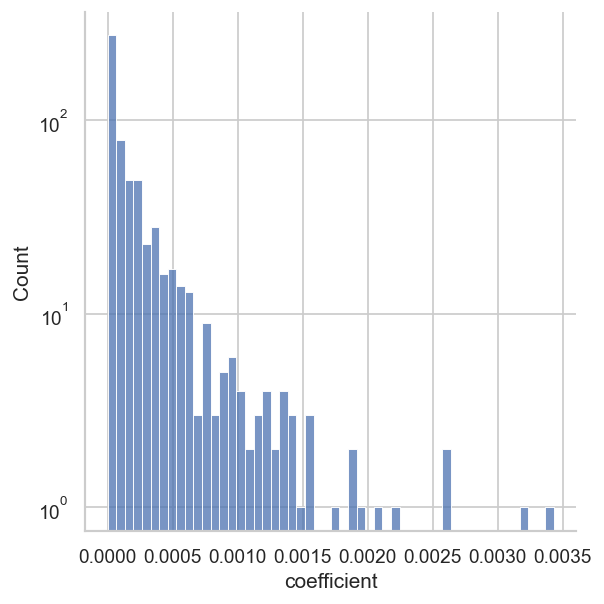

In [22]:
sns.displot(sc).set(xlabel='coefficient',yscale='log')

### Ridge

Ridge essentially works in the same thing as lasso, except that it is using square instead of modulus for penalizing
model coefficients in the loss function:

$$ RSS + \lambda \sum_{i=1}^{N}  \beta_{i}^2 $$

This s called L2 regularization.

Again, as with lasso, we want to evaluate shrinkage for different values of `C`.

Computing regularization path ...
This took 45.447s


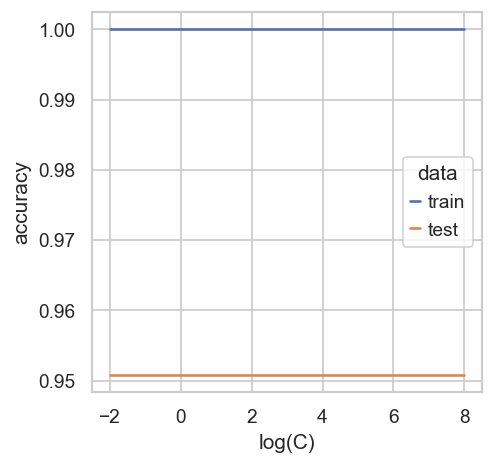

In [23]:
l2_coeffs = eval_reg(X_train, X_test, Y_train, Y_test, penalty="l2")

Inspect coefficients.

In [24]:
cdt = pd.DataFrame(data=l2_coeffs).set_index(np.logspace(-2, 8, 11))
cdt.transpose().abs().describe()

,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03,1.000000e+04,1.000000e+05,1.000000e+06,1.000000e+07,1.000000e+08
count,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04
mean,1.490478e-05,1.504946e-05,1.506454e-05,1.506606e-05,1.506621e-05,1.506622e-05,1.506622e-05,1.506622e-05,1.506622e-05,1.506622e-05,1.506622e-05
std,3.412505e-05,3.446403e-05,3.449935e-05,3.450290e-05,3.450325e-05,3.450329e-05,3.450329e-05,3.450329e-05,3.450329e-05,3.450329e-05,3.450329e-05
min,6.819355e-11,1.265728e-10,1.267026e-11,8.349918e-12,1.045247e-11,1.066273e-11,1.068376e-11,1.068586e-11,1.068607e-11,1.068609e-11,1.068609e-11
25%,1.915323e-06,1.929029e-06,1.930116e-06,1.930231e-06,1.930243e-06,1.930244e-06,1.930244e-06,1.930244e-06,1.930244e-06,1.930244e-06,1.930244e-06
50%,6.067155e-06,6.127248e-06,6.131969e-06,6.132393e-06,6.132452e-06,6.132458e-06,6.132459e-06,6.132459e-06,6.132459e-06,6.132459e-06,6.132459e-06
75%,1.394553e-05,1.408555e-05,1.410003e-05,1.410136e-05,1.410145e-05,1.410146e-05,1.410146e-05,1.410146e-05,1.410146e-05,1.410146e-05,1.410146e-05
max,9.300718e-04,9.395777e-04,9.405648e-04,9.406639e-04,9.406738e-04,9.406748e-04,9.406749e-04,9.406749e-04,9.406749e-04,9.406749e-04,9.406749e-04


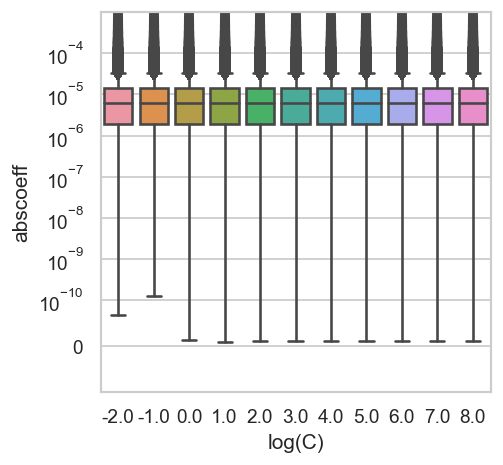

In [25]:
plot_coeffs_dist(l2_coeffs)

Importantly, note that ridge doesn't scale any of the coefficients to 0! Why is this so?

When minimizing loss function, in the simple example of two coefficients, lasso is solving the following constraint
function:

$$ |\beta_{1}| + |\beta_{2}| \leq s $$

and ridge is solving:

$$ \beta_{1}^2 + \beta_{2}^2 \leq s $$

where $$s$$ is a constant specific for each value of $$\lambda$$. This is shown graphically below. Red ellipses are RSS
for different $$\lambda$$, and green areas are constraint functions for lasso (left) and ridge (right) for a given $$s$$.
The final coefficients are then given by the first point where area and contour intersect, and while for ridge this can
happen on one of the axes, implying that coefficient is shrunk to 0, for lasso it generally does not happen.

![img](https://miro.medium.com/max/700/1*XC-8tHoMxrO3ogHKylRfRA.png)
###### An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani

### Elastic net

Finally, elastic net is a feature selection method that is a combination of lasso and ridge. For this, we need to
specify the elastic net mixing parameter `l1_ratio` - setting `l1_ratio=1` is equivalent to using L1
regularization (lasso), while `l1_ratio=0` is equivalent to using L2 regularization (ridge).

Computing regularization path ...
This took 426.462s


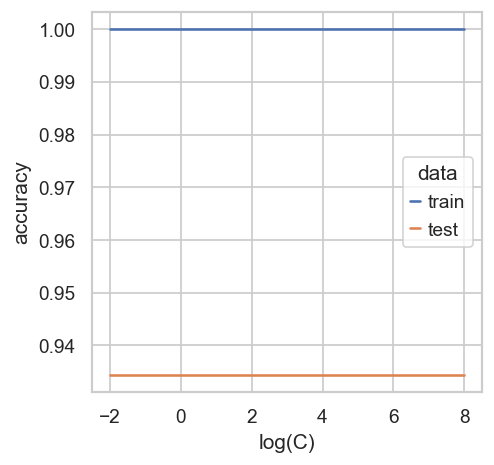

In [26]:
# this takes longer than L1/L2!
elnet_coeffs = eval_reg(X_train, X_test, Y_train, Y_test, penalty="elasticnet", l1_ratio=0.5, solver="saga")

Inspect coefficients.

In [27]:
cdt = pd.DataFrame(data=elnet_coeffs).set_index(np.logspace(-2, 8, 11))
cdt.transpose().abs().describe()

,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03,1.000000e+04,1.000000e+05,1.000000e+06,1.000000e+07,1.000000e+08
count,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04,6.300000e+04
mean,7.855399e-07,9.200079e-07,9.607142e-07,9.796513e-07,9.984592e-07,1.016774e-06,1.028150e-06,1.039287e-06,1.050223e-06,1.060970e-06,1.071535e-06
std,1.377424e-05,1.432557e-05,1.439346e-05,1.441859e-05,1.444313e-05,1.446712e-05,1.448178e-05,1.449623e-05,1.451048e-05,1.452453e-05,1.453840e-05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.711365e-13,5.673102e-14,5.246655e-15,1.244184e-12,9.088671e-13,2.826814e-13
25%,0.000000e+00,0.000000e+00,0.000000e+00,2.668486e-09,5.596122e-09,8.480084e-09,1.027970e-08,1.201796e-08,1.371081e-08,1.538930e-08,1.703551e-08
50%,0.000000e+00,0.000000e+00,9.978228e-09,1.850567e-08,2.732687e-08,3.587734e-08,4.125939e-08,4.649602e-08,5.165588e-08,5.662070e-08,6.148570e-08
75%,0.000000e+00,0.000000e+00,3.858555e-08,5.799471e-08,7.726080e-08,9.603207e-08,1.077163e-07,1.191234e-07,1.302525e-07,1.413593e-07,1.521663e-07
max,7.617262e-04,7.797813e-04,7.818760e-04,7.826012e-04,7.833306e-04,7.840513e-04,7.844469e-04,7.848564e-04,7.852665e-04,7.856751e-04,7.860808e-04


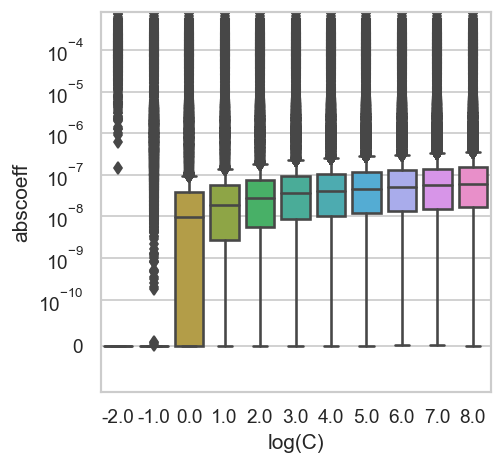

In [28]:
plot_coeffs_dist(elnet_coeffs)

***
Thoughts on feature selection?

![img](https://pbs.twimg.com/media/Exf7fhlVIAErct9?format=jpg&name=small)

## Dimensionality reduction

In cases when we are working with a dataset that has both large number of observations and features, we might consider
performing feature extraction (often also referred to just as dimensionality reduction, in strict sense).
A typical example would be single cell experiment, with tens of thousands of cells and tens of thousands of features
(gene expression, methylation, or ChIP signal etc.) measured in each cell.

Most commonly used feature extraction methods are:
- PCA
- tSNE
- UMAP

### PCA

PCA is a linear transformation method that identifies the directions (principal components) that maximize the variance
of the data.

For a simplified step-by-step explanation of maths behind PCA, check out [StatQuest video](https://youtu.be/FgakZw6K1QQ).

PCA is using a method called singular value decomposition (SVD) to transform our original data matrix. Essentially, it
computes independent (i.e. perpendicular) singular vectors (eigenvectors) $$\nu$$ along which the data are spread.
Each eigenvector has the corresponding singular value (eigenvalue) $$\lambda$$, which is the sum of squared distances
between the data points projected on the eigenvector and the center of the data.

$$ \sum_{}{}{\nu}=\lambda\nu $$

Eigenvectors associated with eigenvalues that are much higher than others contain more information about our data
distribution. Vice versa, eigenvalues that are close to 0 are less informative, and we usually drop those to reduce
the dimensionality of our data.

To generate a representation of the data in the lower-dimensional space, PCA collects eigenvectors with the highest
eigenvalues in an eigenvector matrix $$ W $$ and transforms the data into the new subspace by multiplication.

$$ y=W^{T}\times x $$

For PCA we first need to standardize features by removing the mean and scaling to unit variance. Again, this is necessary
because a feature that has orders of magnitude larger variance than others might dominate the model.

array([1., 1., 1., ..., 1., 1., 1.])

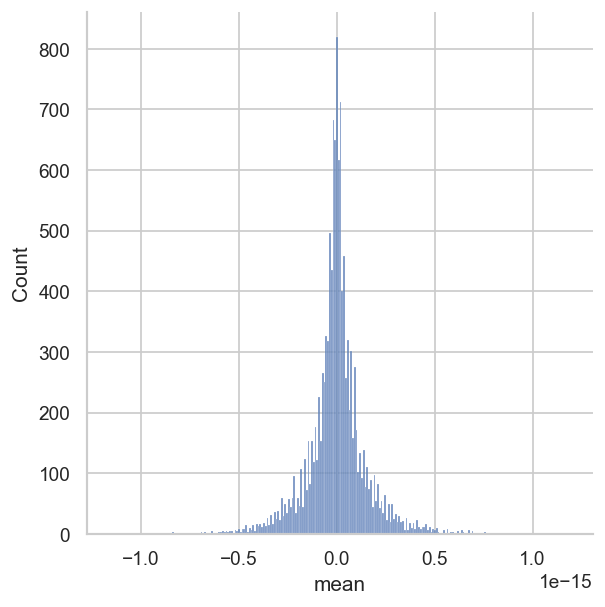

In [39]:
from sklearn.preprocessing import StandardScaler

tmat = dt.drop('Class', axis=1)
X = StandardScaler().fit_transform(tmat)

#scaled data has mean 0 and var 1
sns.displot(X.mean(axis=0)).set(xlabel='mean')
X.std(axis=0)

PCA

In [40]:
from sklearn.decomposition import PCA

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# inspect the shape
pca_reduced_data.shape

(201, 6)

Plot the data projected on the first two principal components

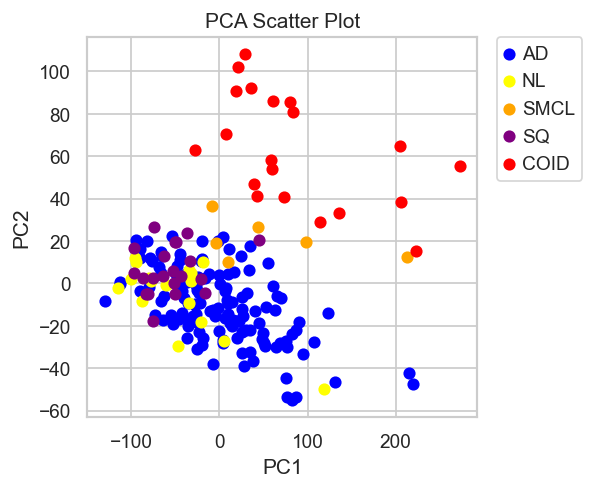

In [42]:
colors = ['blue', 'yellow', 'orange', 'purple', 'red']
cl = ['AD', 'NL', 'SMCL', 'SQ', 'COID']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

We see that all samples cannot be separated using the two first principal components, which account for somewhat less
than 40% of the variance in the data.

[0.38545617 0.06265541 0.03784754 0.02815259 0.02076094 0.01463913]


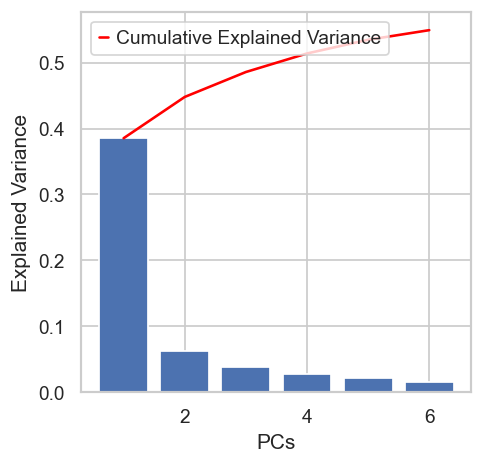

In [43]:
print(pca.explained_variance_ratio_)
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

Squamous cell lung carcinoma (SQ) and adenocarcinoma (AD) samples are largely overlapping with the normal lung samples,
whereas the two neuroendocrine tumors are separating better, so we only select the former and repeat the same exercise.

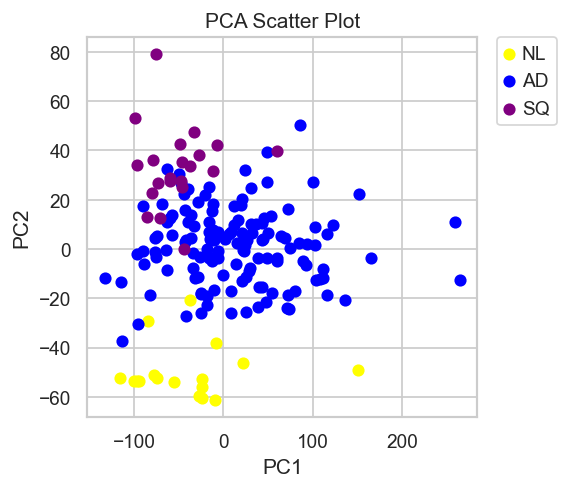

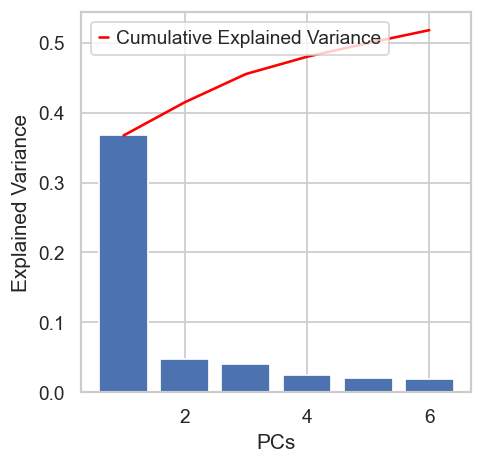

In [44]:
selected = classes.isin(['NL','SQ','AD'])
tmatfilt = tmat.filter(regex=r'(NL|SQ|AD)', axis=0)

# scale
scaler = StandardScaler()
X = StandardScaler().fit_transform(tmatfilt)

# classes from sample names
samples = pd.Series(list(tmatfilt.index))
classes = samples.str.extract(r'(NL|SQ|AD)')
classes.value_counts()

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# plot
colors = ['yellow', 'blue', 'purple']
cl = ['NL', 'AD', 'SQ']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

# variance
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

Now the two tumor types are better separated from the normal sample. We see that the PC2, along which they are separated,
explains a small proportion of variance, and the majority of heterogeneity is between samples within the classes (in the
direction of PC1).

In [45]:
pca.explained_variance_ratio_

array([0.36734883, 0.04752435, 0.04041885, 0.02476722, 0.01967118,
       0.01838619])

We do the same for the two neuroendocrine tumors.

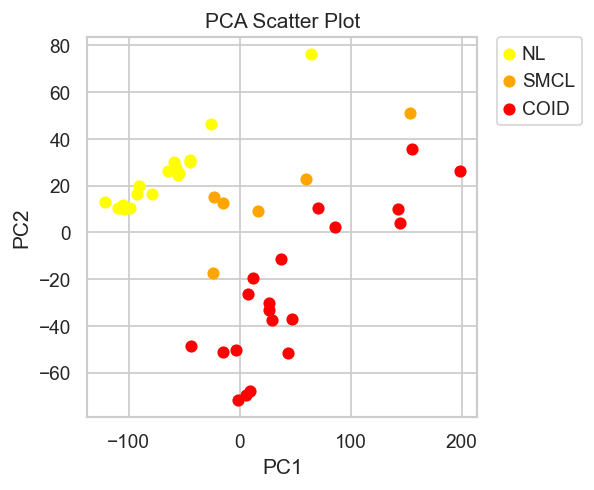

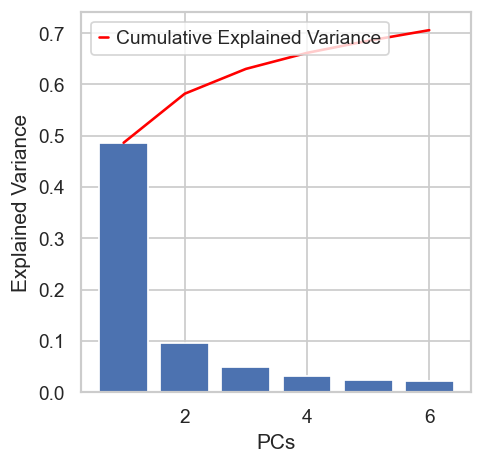

array([0.48635528, 0.09565876, 0.04836801, 0.03125754, 0.02360631,
       0.02072489])

In [47]:
selected = classes.isin(['NL','SMCL','COID'])
tmatfilt = tmat.filter(regex=r'(NL|SMCL|COID)', axis=0)

# scale
scaler = StandardScaler()
X = StandardScaler().fit_transform(tmatfilt)

# classes from sample names
samples = pd.Series(list(tmatfilt.index))
classes = samples.str.extract(r'(NL|SMCL|COID)')
classes.value_counts()

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# plot
colors = ['yellow', 'orange', 'red']
cl = ['NL', 'SMCL', 'COID']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

# variance
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

pca.explained_variance_ratio_

An important point to make here is that in PCA we are trying to find the axes with maximum variances where the data is
most spread. This is not a classification algorithm, and labeling the points is completely independent of the model
building and its performance. A related linear transformation method that maximizes the variance in the data, and
additionally finds the directions that maximize the separation between different classes is called Multiple Discriminant
Analysis (MDA).

When it comes to interpretability of PCA models, we already mentioned that the PCs represent directions of variance in
the data. We can also identify the key variables (here, genes) that contribute to the explanation of most variance in
the data set. The importance of each feature is reflected by the magnitude of the corresponding values in the
eigenvectors, where higher magnitude means higher contribution of that feature to the PC.

Let’s find the most important features.

[ 3545  3434 10238  7270  4459  2224   167  3841 10388 10602  3247  2523
 10032  3921  3323  7571  3808   669  8832  6008]
[0.01246331 0.01247476 0.01248035 0.01248582 0.01248687 0.01248706
 0.01248711 0.01248739 0.01248991 0.01249531 0.01249598 0.01250237
 0.01250483 0.01250522 0.01250923 0.0125209  0.0125339  0.01253919
 0.01254339 0.01254988]
['39212_at', '38861_at', '41509_at', '40880_r_at', '41683_i_at', '34896_at', '31407_at', '39987_at', '41843_r_at', '33187_r_at', '38195_at', '35914_r_at', '40943_at', '40307_at', '38511_at', '32258_r_at', '39954_r_at', '32386_at', '37349_r_at', '37223_at']


Text(0, 0.5, 'Gene')

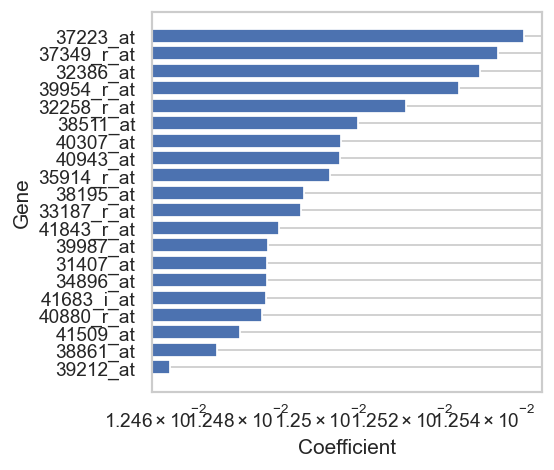

In [48]:
# get top genes to plot
ids = np.argsort(abs(pca.components_)[0,:],axis=0)[-20:]
print(ids)
coeff = abs(np.transpose(pca.components_)[ids,:][:,0])
print(coeff)
labels = np.asarray(tmatfilt.columns)[ids].tolist()
print(labels)

plt.barh(labels,coeff)
plt.xscale('log',base=10)
plt.xlabel('Coefficient')
plt.ylabel('Gene')


Even the most important genes have relatively low coefficients, which is biologically expected. A more informative
approach might be to look at the relative importance of the genes. We also want to see more informative names.

In [103]:
# get gene names
geneannot = pd.read_table("data/Annotation_genes.tsv")
labdt = geneannot.loc[geneannot['probe set'].isin(labels)]
indices = list(reversed(range(1,len(labels)+1)))
ldt = pd.DataFrame(list(zip(indices,labels,labdt['gene'])), columns=['indexx', 'probe set', 'gene'])
ldt.sort_values('indexx')


,indexx,probe set,gene
19,1,37223_at,Cluster Incl AL046961:DKFZp586J0417_r1 Homo s...
18,2,37349_r_at,Cluster Incl W28275:44g12 Homo sapiens cDNA /g...
17,3,32386_at,heat shock 70kD protein 9B (mortalin-2)
16,4,39954_r_at,Cluster Incl AA009569:zi04h03.r1 Homo sapiens...
15,5,32258_r_at,Cluster Incl AI817618:wk39f01.x1 Homo sapiens...
14,6,38511_at,telomeric repeat binding factor (NIMA-interact...
13,7,40307_at,chloride channel 3
12,8,40943_at,"sarcoglycan, beta (43kD dystrophin-associated ..."
11,9,35914_r_at,"branched chain keto acid dehydrogenase E1, bet..."
10,10,38195_at,Cluster Incl AF038204:Homo sapiens clone 23849...
